# Dataset statistics

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

roi_image_dir = './data/roi-severity/train'
transform = transforms.Compose([transforms.ToTensor()])
dataset = ImageFolder(roi_image_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=False)

test_roi_image_dir = './data/roi-severity/test'
dataset = ImageFolder(test_roi_image_dir, transform=transform)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

def compute_mean_std(image_dir, loader):
    mean = 0.0
    std = 0.0
    total_pixels = 0

    for batch in loader:
        images = batch[0]
        batch_pixels = images.numel()
        mean += images.sum().item()
        std += (images ** 2).sum().item()
        total_pixels += batch_pixels

    mean /= total_pixels
    std = (std / total_pixels - mean ** 2) ** 0.5

    print(f"{image_dir} - Mean: {mean}, Std: {std}")

In [ ]:
compute_mean_std(roi_image_dir, train_loader)
compute_mean_std(test_roi_image_dir, test_loader)

./data/roi-severity/train - Mean: 0.5451273132302907, Std: 0.1577124629250931
./data/roi-severity/test - Mean: 0.5476973526405565, Std: 0.1609649724274023


## Dataset augmentations

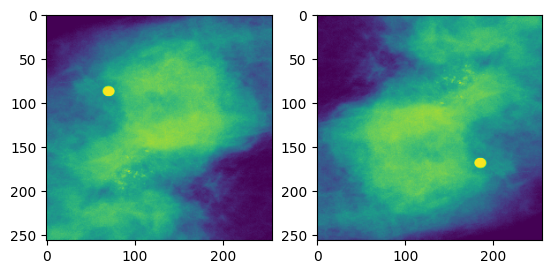

In [59]:
import cv2
import albumentations as A
import matplotlib.pyplot as plt

def augment_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    augmented = augmentation_pipeline(image=image)['image']
    return image, augmented
    
augmentation_pipeline = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ElasticTransform(p=0.5, alpha=10, sigma=50),
    ])

test_image = './figures/calc_malignant_sample.png'
original_image, augmented_image = augment_image(test_image)

f, axarr = plt.subplots(1,2)

axarr[0].imshow(original_image)
axarr[1].imshow(augmented_image)

plt.show()